# Non-ALS Domains

This notebook generates analysis for ADNI and PPMI datasets

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
import joblib
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from analysis_utils import *

from copy import deepcopy
from scipy.stats import hypergeom

# Formatting params
col_palette = ['#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb']
parameters = {'axes.labelsize': 25,
              'xtick.labelsize':15,
              'ytick.labelsize':25,
             'legend.fontsize':25,
              'legend.loc':'upper right',
              'xtick.labelsize':25,
              'ytick.labelsize':25,
             'pdf.fonttype':42, 
             'ps.fonttype':42, 
             'font.family':'arial'}
plt.rcParams.update(parameters)

# Formatting params
sns.set(font_scale=2)
sns.set_style("white")

col_palette = ['#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb']

## Visualize processed model data

In [3]:
adni_data_dict = joblib.load('data/model_data/5_nonals_domains/data_adni_min3_adas13.pkl')
ppmi_data_dict = joblib.load('data/model_data/5_nonals_domains/data_ppmi_min3_updrs.pkl')

No. pats: 331
No. pats: 397


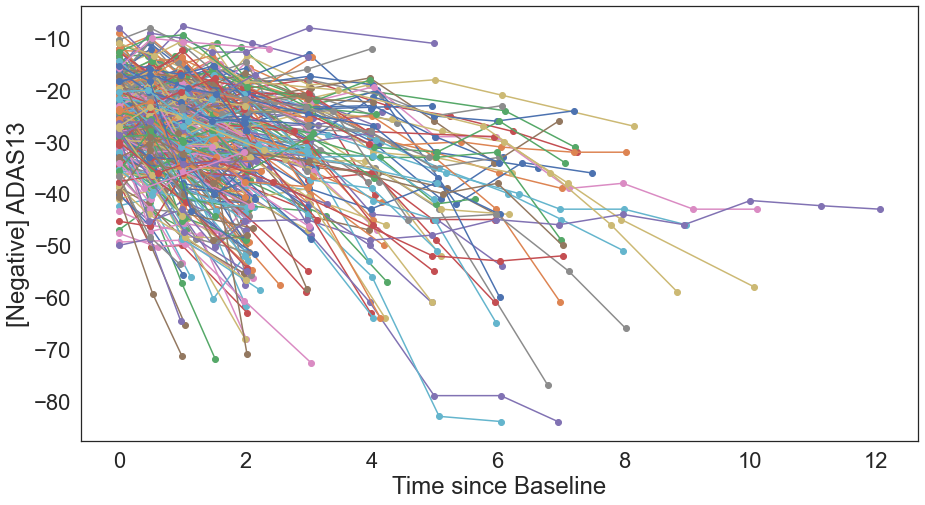

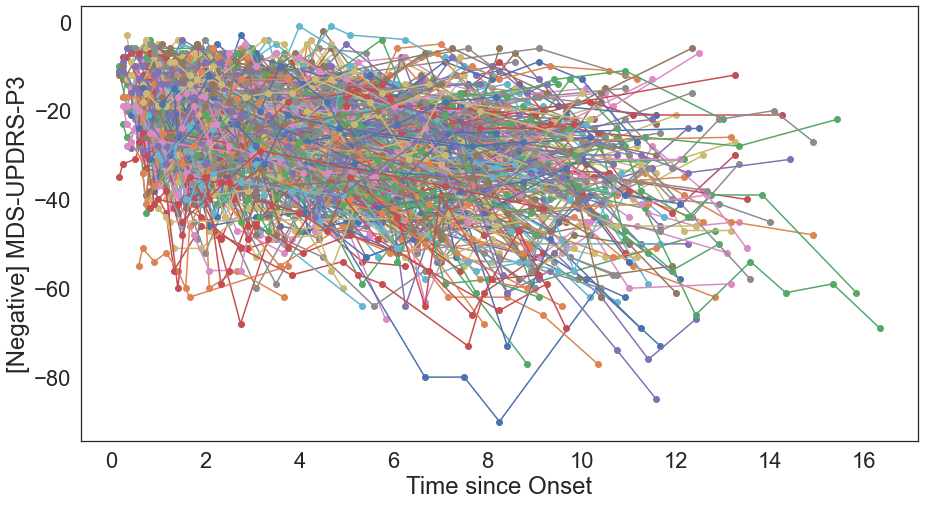

In [4]:
fig, ax = plt.subplots(figsize=(15,8))
print('No. pats:',  len(adni_data_dict['SI']))
_ = ax.plot(adni_data_dict['XA'].T, adni_data_dict['YA'].T, 'o-',)
_ = ax.set_xlabel('Time since Baseline')
_ = ax.set_ylabel('[Negative] ADAS13')

fig, ax = plt.subplots(figsize=(15,8))
print('No. pats:',  len(ppmi_data_dict['SI']))
_ = ax.plot(ppmi_data_dict['XA'].T, ppmi_data_dict['YA'].T, 'o-',)
_ = ax.set_xlabel('Time since Onset')
_ = ax.set_ylabel('[Negative] MDS-UPDRS-P3')

# Visualize MoGP clusters

In [5]:
def flip_model(cmodel, cdata):
    curmean = cmodel.mean
    curstd = cmodel.std
    active_comps_ids = np.where(cmodel.allocmodel.Nk > 0)[0]
    for a in active_comps_ids:
        cmodel.obsmodel[a].model.normalizer.mean = -curmean
        cmodel.obsmodel[a].model.normalizer.std = -curstd
        
    cdata['YA']=-cdata['YA']
    return cmodel, cdata

In [6]:
def plot_mogp_panel_nonals(model, data, disp_clust=12, k_alph_flag=True, mogp_color='b', slope_color='r', max_x=8, x_step=2.0, y_label=[0,24,48], y_minmax=(-5, 53)):
    """Plot full panel, including calculating slope per cluster"""
    fig, axs = plt.subplots(math.ceil(disp_clust/4), 4, figsize=(20, 3*(math.ceil(disp_clust/4))), sharex=True, sharey=True)

    nc = len(np.where(model.allocmodel.Nk > 0)[0])
    idx = np.argsort(-model.allocmodel.Nk)[0:nc]
    
    df_disp_clust = pd.DataFrame(columns=['k', 'k_alph', 'estim_diff'])
    for i, k in enumerate(idx[:disp_clust]):
        if k_alph_flag:
            k_alph = ascii_lowercase[i]
        else:
            k_alph = None
        
        axs.flat[i], num_pat = plot_mogp_by_clust(axs.flat[i], model, data, k, data_col='k', model_col=mogp_color, anchor=False) 
        estim_diff = plot_slope_by_clust(axs.flat[i], model, k, slope_col=slope_color) 
        axs.flat[i] = format_panel_axs_nonals(axs.flat[i], k_alph, num_pat, k_alph_flag, max_x=max_x, x_step=x_step, y_label=y_label, y_minmax=y_minmax)
        
        df_disp_clust = df_disp_clust.append({'k': k, 'k_alph': k_alph, 'estim_diff': estim_diff}, ignore_index=True)
    
    return fig, axs, df_disp_clust


def format_panel_axs_nonals(ax, alph_lab, num_pat, k_alph_flag, fontsize_numpat=25, fontsize_alph=25, max_x=8, x_step=2.0, y_label=[0,24,48], y_minmax=(-5, 53)):
    """Scale axes to original data, label with number of patients per cluster"""
    ax = format_mogp_axs(ax, max_x=max_x, x_step=x_step, y_label=y_label, y_minmax=y_minmax)

    ax.get_legend().remove()
    ax.text(0.97, 0.95, num_pat, transform=ax.transAxes, va='top', ha='right', fontsize=fontsize_numpat)
    if k_alph_flag:
        ax.text(0.05, 0.95, alph_lab, transform=ax.transAxes, va='top', ha='left', fontsize=fontsize_alph)
    return ax

In [7]:
def set_format_params_nonals(cur_proj):
    if cur_proj is 'adni':
        xlab_txt='Time since Baseline Visit (Years)'
        ylab_txt='ADAS-Cog-13'
        cur_model=adni_map_mod
        cur_data=adni_data
        cmax_x = 10
        cx_step = 2
        cy_label=[0,42,85] 
        cy_minmax=(-5, 90)
    else:
        xlab_txt='Time since Symptom Onset (Years)'
        ylab_txt='MDS-UPDRS (Part III - Off Med)'
        cur_model=ppmi_map_mod
        cur_data=ppmi_data
        cmax_x = 20
        cx_step = 4
        cy_label=[0,50,100] 
        cy_minmax=(-10, 110)
    
    return xlab_txt, ylab_txt, cur_model, cur_data, cmax_x, cx_step, cy_label, cy_minmax

In [8]:
def plot_adni_ppmi(ext_dc_lab=None, save=True, first_legend_only=True):
    label_projs = {'adni': 'ADNI', 'ppmi': 'PPMI'}

    for cur_proj in ['adni', 'ppmi']:
        # Select best MAP model
        print(cur_proj)
        cur_model_path = exp_path / 'results' / 'rbf'
        xlab_txt, ylab_txt, cur_model, cur_data, cmax_x, cx_step, cy_label, cy_minmax = set_format_params_nonals(cur_proj)
        
        if ext_dc_lab is None:
            ext_dc = 8
            suff = 'alphclust'
            k_alph_flag=True
        else:
            ext_dc = get_clust_num_perc(cur_model, vis_perc=ext_dc_lab)
            ext_dc = math.ceil(ext_dc/4)*4 #round to the nearest 4 
            suff='{}'.format(ext_dc_lab)
            k_alph_flag=False
        
        cur_fig, cur_axs, df_clust = plot_mogp_panel_nonals(cur_model, cur_data, disp_clust=ext_dc, k_alph_flag=k_alph_flag, mogp_color=col_palette[0], slope_color=col_palette[3], max_x=cmax_x, x_step=cx_step,  y_label=cy_label, y_minmax=cy_minmax)


        # Edit x and y labels, title
        x_lab = cur_fig.text(0.5, 0.04, xlab_txt, va='top', ha='center', transform=cur_fig.transFigure, fontsize=30)
        y_lab = cur_fig.text(0.09, 0.5, ylab_txt, rotation='vertical', va='center', ha='right', transform=cur_fig.transFigure, fontsize=30)
        study_title = cur_fig.text(0.1, 0.92, 'Study: {}'.format(label_projs[cur_proj]),  ha='left', transform=cur_fig.transFigure, fontweight='bold', fontsize=30)
        clust_num_title = cur_fig.text(0.9, 0.92, '{} Total Clusters'.format(len(np.unique(cur_model.z))), ha='right', transform=cur_fig.transFigure)

        if (first_legend_only and cur_proj=='adni') | (not first_legend_only):
            # Create legend
            blue_line = matplotlib.lines.Line2D([], [], color=col_palette[0], linewidth=3)
            blue_patch = matplotlib.patches.Patch(color=col_palette[0], alpha=0.25, linewidth=0)
            red_line = matplotlib.lines.Line2D([], [], color=col_palette[3], linestyle='dashed', linewidth=3)
            black_dots = matplotlib.lines.Line2D([], [], color='black', marker='o', markersize=15)
            leg = cur_axs.flat[0].legend(((blue_line, blue_patch), black_dots, red_line), ('MoGP Prediction', 'Data', 'First Year Slope',), frameon=False, loc='lower left', bbox_to_anchor=(-0.22, 1.3), ncol=3)             
            
        # Save cur_figure
        if save:
            cur_fig.savefig('reports/supp_fig_fullpanel_{}_{}.pdf'.format(cur_proj, suff), bbox_inches='tight')

In [9]:
# Select best MAP seed for each

exp_path = Path('data/model_data/5_nonals_domains')

mod_res_path = exp_path / 'results' / 'rbf'

# Load ADNI
adni_data_neg = joblib.load(exp_path / 'data_adni_min3_adas13.pkl')
adni_map_mod_neg = get_map_model(mod_res_path, 'model_adni_min3_adas13')

# Load PPMI
ppmi_data_neg = joblib.load(exp_path / 'data_ppmi_min3_updrs.pkl')
ppmi_map_mod_neg = get_map_model(mod_res_path, 'model_ppmi_min3_updrs')

best seed: 0, ll -1597.2778725660314
seed did not pass monotonicity test: 2
seed did not pass monotonicity test: 3
seed did not pass monotonicity test: 4
best seed: 0, ll -3924.744026907054


In [10]:
#prob don't need deepcopy if just running once 
adni_data=deepcopy(adni_data_neg)
adni_map_mod=deepcopy(adni_map_mod_neg)
ppmi_data=deepcopy(ppmi_data_neg)
ppmi_map_mod=deepcopy(ppmi_map_mod_neg)

adni_map_mod, adni_data = flip_model(adni_map_mod, adni_data)
ppmi_map_mod, ppmi_data = flip_model(ppmi_map_mod_neg, ppmi_data_neg)

In [11]:
# # source data
# joblib.dump(adni_map_mod, 'reports/adni_model.pkl')
# joblib.dump(ppmi_map_mod, 'reports/ppmi_model.pkl')

adni
ppmi


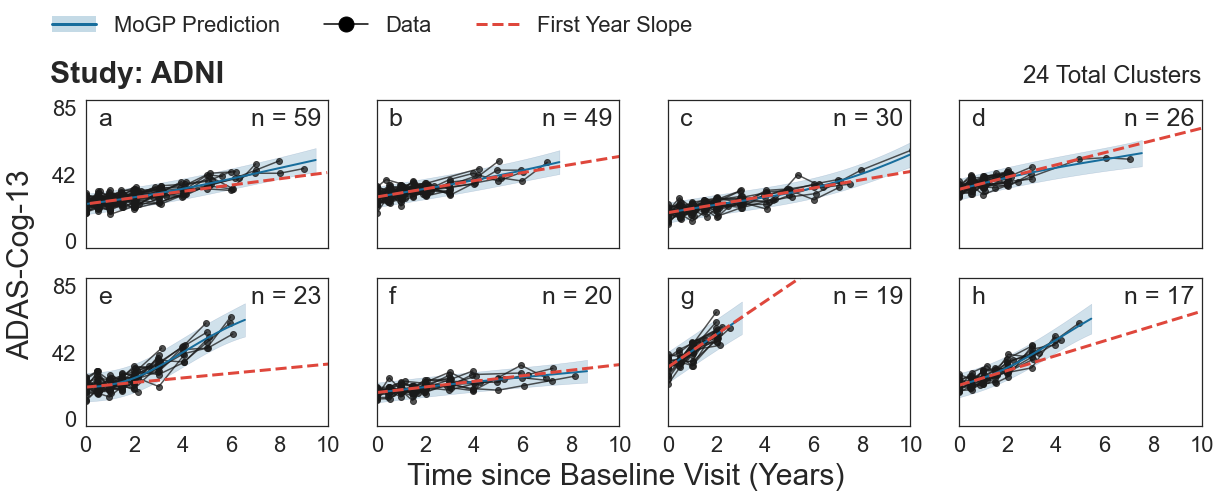

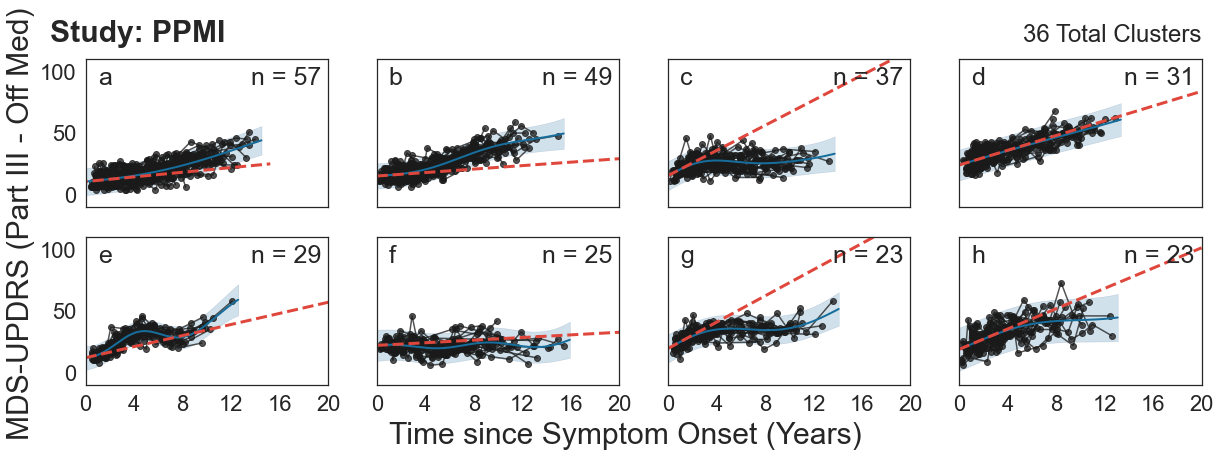

In [12]:
# plot_adni_ppmi(ext_dc_lab=None, save=True)
plot_adni_ppmi(ext_dc_lab=None, save=False)

adni
ppmi


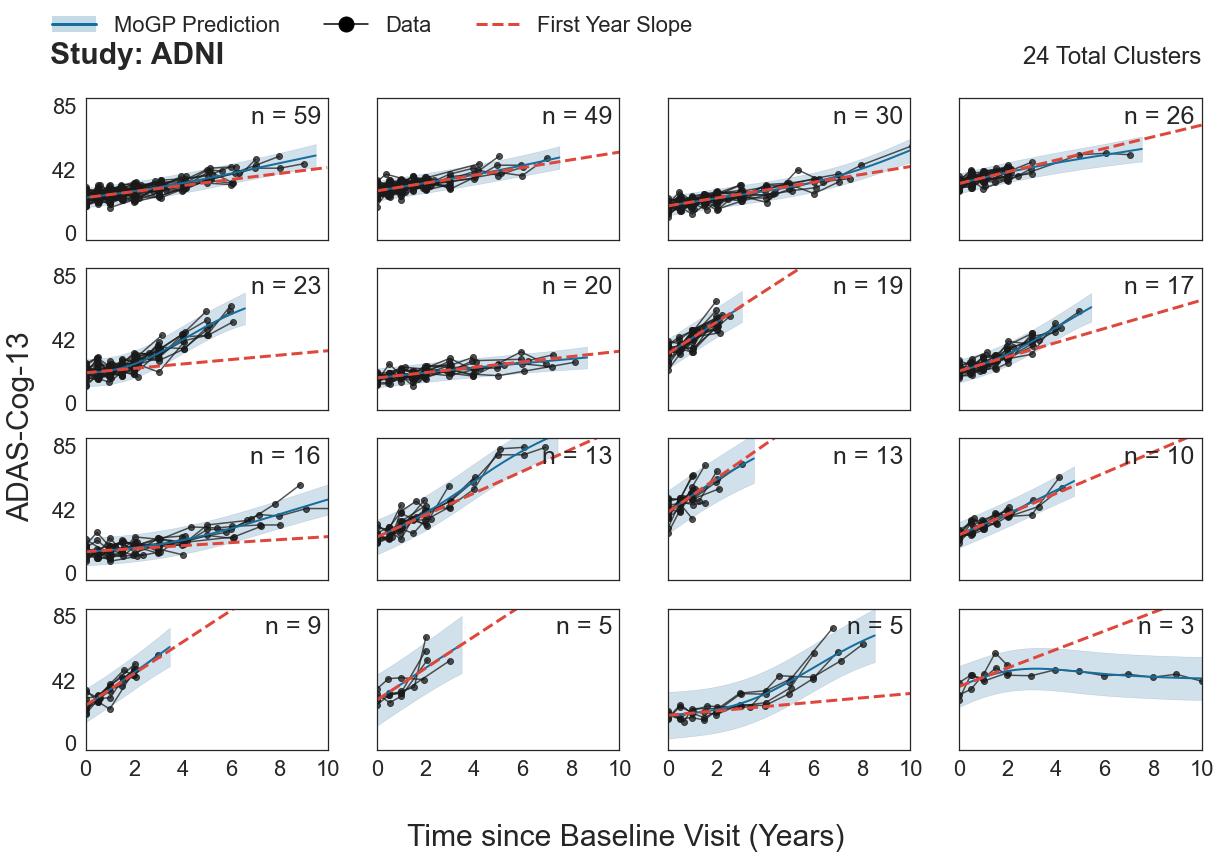

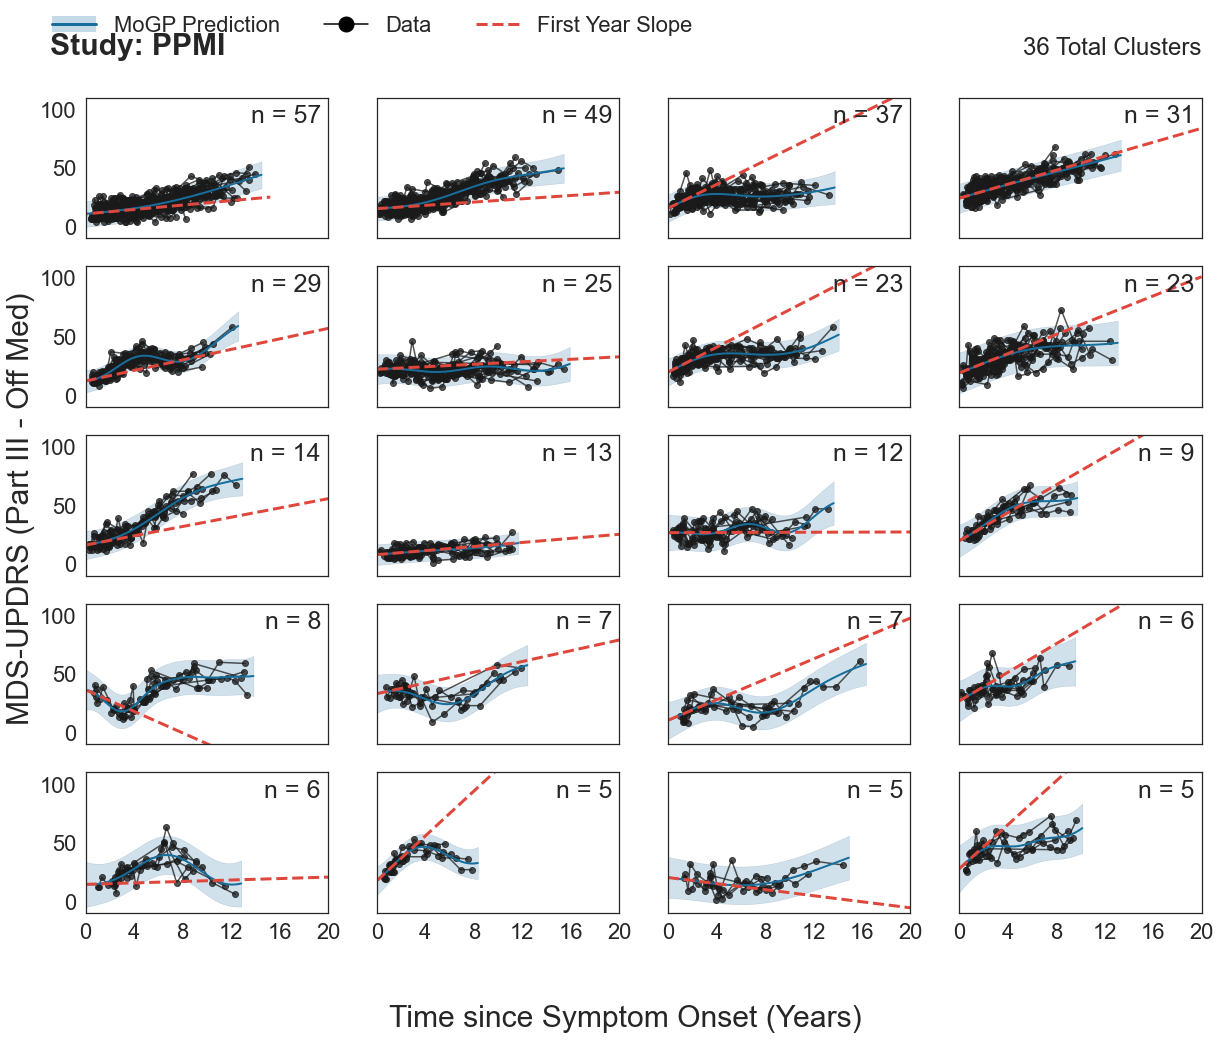

In [13]:
plot_adni_ppmi(ext_dc_lab=0.9, save=True, first_legend_only=False)

## Check cluster correlation with clinical features

### ADNI: MCI to AD conversion

In [14]:
# Load clinical files:
df_ad = pd.read_csv('data/raw_data/adni/Study Info/ADNIMERGE.csv')

 /Users/divyar/Documents/Grad - Divya/Research/mogp/mogpvenv-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning:Columns (19,20,21,104,105,106) have mixed types.Specify dtype option on import or set low_memory=False.


In [15]:
# Calculate frequency of conversion and APOE4
adni_clust = pd.DataFrame(list(zip(adni_data['SI'], adni_map_mod.z)), columns=['PTID', 'cluster'])
adni_clin = df_ad[['PTID','DX_bl', 'APOE4']]
adni_cmerge = cmerge(adni_clust, adni_clin, feat='DX_bl', ptid='PTID')
adni_diag_conver= check_clust_freq(adni_cmerge, feat='DX_bl', ptid='PTID')

adni_cmerge_apo = cmerge(adni_clust, adni_clin, feat='APOE4', ptid='PTID')
apoe4 = check_clust_freq(adni_cmerge_apo, feat='APOE4', ptid='PTID')

#Formatting
adni_diag_conver['% (No.) AD']=['{:.2f}% ({})'.format(i[0]*100, i[1]) for i in zip(adni_diag_conver["AD_freq"],adni_diag_conver["AD"])]
adni_diag_conver['% (No.) MCI']=['{:.2f}% ({:.0f})'.format(i[0]*100, i[1]) for i in zip(adni_diag_conver["LMCI_freq"],adni_diag_conver["LMCI"])]
adni_diag_conver['AD P-Val']=['{:.2e}'.format(i) for i in adni_diag_conver['AD_pval']]
adni_diag_conver['MCI P-Val']=['{:.2e}'.format(i) for i in adni_diag_conver['LMCI_pval']]

adni_diag_conver.head(n=8)
apoe4.head(n=8)

,AD,CN,LMCI,clust_size,AD_freq,LMCI_freq,CN_freq,AD_pval,LMCI_pval,CN_pval,% (No.) AD,% (No.) MCI,AD P-Val,MCI P-Val
cluster,,,,,,,,,,,,,,
6,28.0,NaN,31.0,59,0.474576,0.525424,NaN,0.112843,0.114232,NaN,47.46% (28.0),52.54% (31),1.13e-01,1.14e-01
11,30.0,NaN,19.0,49,0.612245,0.387755,NaN,0.010393,0.014001,NaN,61.22% (30.0),38.78% (19),1.04e-02,1.40e-02
7,5.0,1.0,24.0,30,0.166667,0.800000,0.033333,0.000304,0.000895,0.226148,16.67% (5.0),80.00% (24),3.04e-04,8.95e-04
4,23.0,NaN,3.0,26,0.884615,0.115385,NaN,0.000004,0.000007,NaN,88.46% (23.0),11.54% (3),4.32e-06,6.62e-06
19,4.0,NaN,19.0,23,0.173913,0.826087,NaN,0.002190,0.001680,NaN,17.39% (4.0),82.61% (19),2.19e-03,1.68e-03
194,2.0,NaN,18.0,20,0.100000,0.900000,NaN,0.000384,0.000288,NaN,10.00% (2.0),90.00% (18),3.84e-04,2.88e-04
95,18.0,NaN,1.0,19,0.947368,0.052632,NaN,0.000006,0.000009,NaN,94.74% (18.0),5.26% (1),6.39e-06,9.07e-06
247,4.0,NaN,13.0,17,0.235294,0.764706,NaN,0.030312,0.026030,NaN,23.53% (4.0),76.47% (13),3.03e-02,2.60e-02


,0.0,1.0,2.0,clust_size,2.0_freq,1.0_freq,0.0_freq,2.0_pval,1.0_pval,0.0_pval
cluster,,,,,,,,,,
6,15.0,32.0,12.0,59,0.203390,0.542373,0.254237,0.127158,0.073059,0.046433
11,18.0,23.0,8.0,49,0.163265,0.469388,0.367347,0.153930,0.119018,0.109373
7,11.0,15.0,4.0,30,0.133333,0.500000,0.366667,0.165584,0.149656,0.144415
4,6.0,16.0,4.0,26,0.153846,0.615385,0.230769,0.204253,0.064483,0.094525
19,3.0,10.0,10.0,23,0.434783,0.434783,0.130435,0.002404,0.150682,0.017666
194,10.0,7.0,3.0,20,0.150000,0.350000,0.500000,0.231782,0.084927,0.051226
95,8.0,9.0,2.0,19,0.105263,0.473684,0.421053,0.187024,0.185095,0.133913
247,6.0,10.0,1.0,17,0.058824,0.588235,0.352941,0.121460,0.136927,0.201181


In [16]:
adni_diag_conver.to_csv('reports/supp_table_ad_conv.csv')

### PPMI: TD and PIGD subtypes

[Calculation](https://movementdisorders.onlinelibrary.wiley.com/doi/full/10.1002/mds.25383): To calculate the MDS-UPDRS TD/PIGD score, the mean of MDS-UPDRS items 2.10, 3.15a, 3.15b, 3.16a, 3.16b, 3.17a, 3.17b, 3.17c, 3.17d, 3.17e, and 3.18 is divided by the mean of MDS-UPDRS items 2.12, 2.13, 3.10, 3.11, and 3.12. If the resultant ratio is ≥1.15. then the patient is classified with TD. If the ratio is ≤0.90, then the patient is classified with PIGD. If the ratio is between 0.90 and 1.15, then the patient is classified as indeterminate




In addition, patients who had a positive mean in the numerator and a zero in the denominator were classified as TD; patients with a zero in the numerator and a positive mean in the denominator were classified as PIGD, and patients with zeros in both the numerator and denominator were classified as indeterminate 

In [17]:
# calculate PD type
ppmi_path = 'data/raw_data/ppmi/'
mds3 = pd.read_csv(ppmi_path + 'MDS_UPDRS_Part_III.csv')
mds2 = pd.read_csv(ppmi_path + 'MDS_UPDRS_Part_II__Patient_Questionnaire.csv')

mds2 = mds2.drop(columns=['REC_ID', 'PAG_NAME', 'NUPSOURC', 'ORIG_ENTRY', 'LAST_UPDATE'])
mds3 = mds3.drop(columns=['REC_ID', 'ORIG_ENTRY', 'LAST_UPDATE'])

mds = mds2.merge(mds3, how='outer', on=['PATNO','EVENT_ID','INFODT'])
mds = mds.set_index(['PATNO', 'EVENT_ID', 'INFODT']).apply(pd.to_numeric, errors='coerce').reset_index()
mds = mds.groupby(['PATNO', 'EVENT_ID', 'INFODT']).mean().reset_index()

# Calculate PD subtypes
num_mets = ['NP2TRMR', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR','NP3KTRML',
            'NP3RTARU','NP3RTALU','NP3RTARL','NP3RTALL', 'NP3RTALJ','NP3RTCON']
dem_mets = ['NP3GAIT','NP3FRZGT','NP3PSTBL']

numscores = mds[num_mets].apply(pd.to_numeric, errors='coerce').mean(axis=1)
demscores = mds[dem_mets].apply(pd.to_numeric, errors='coerce').mean(axis=1)

mds['td-pigd']=numscores/demscores
mds['td-pigd'].replace([np.inf, -np.inf], np.nan, inplace=True)

mds['td-pigd-lab']=np.where(mds['td-pigd']>=1.15, 'TD', pd.NA)
mds['td-pigd-lab'].fillna(pd.Series(np.where(mds['td-pigd']<=0.9, 'PIGD', pd.NA)), inplace=True)
mds['td-pigd-lab'].fillna(pd.Series(np.where(((mds['td-pigd']>0.9)&(mds['td-pigd']<1.15)), 'IND', pd.NA)), inplace=True)

mds['td-pigd-lab'].fillna(pd.Series(np.where((numscores>0)&(demscores==0), 'TD', pd.NA)), inplace=True)
mds['td-pigd-lab'].fillna(pd.Series(np.where((numscores==0)&(demscores>0), 'PIGD', pd.NA)), inplace=True)
mds['td-pigd-lab'].fillna(pd.Series(np.where((numscores==0)&(demscores==0), 'IND', pd.NA)), inplace=True)

# tdbl = df.merge(mds[['PATNO', 'EVENT_ID', 'INFODT', 'td-pigd-lab']], on=['PATNO', 'EVENT_ID', 'INFODT'])
tdbl = mds[mds['EVENT_ID']=='BL']

# medst =  EVENT_ID == ‘ST’ or the first visit where PDMEDDT is not NaN
medst = mds[mds['EVENT_ID']=='ST']

 /Users/divyar/Documents/Grad - Divya/Research/mogp/mogpvenv-3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning:Columns (10,11,17,18,19,20,21,32) have mixed types.Specify dtype option on import or set low_memory=False.


In [18]:
stable_ind = (mds.groupby('PATNO')['td-pigd-lab'].nunique())[(mds.groupby('PATNO')['td-pigd-lab'].nunique())==1].index
td_stable = mds[mds['PATNO'].isin(stable_ind)][['PATNO', 'td-pigd-lab']].dropna().drop_duplicates()

In [19]:
# Number of stable vs unstable subtype
(mds.groupby('PATNO')['td-pigd-lab'].nunique()).value_counts()

1    798
2    605
3    444
0      3
Name: td-pigd-lab, dtype: int64

In [20]:
ppmi_clust = pd.DataFrame(list(zip(ppmi_data['SI'], ppmi_map_mod.z)), columns=['PATNO', 'cluster'])
# ppmi_clin = tdbl[['PATNO','td-pigd-lab']].drop_duplicates()
ppmi_clin = td_stable[['PATNO','td-pigd-lab']].drop_duplicates()

ppmi_cmerge = cmerge(ppmi_clust, ppmi_clin, feat='td-pigd-lab', ptid='PATNO')
ppmi_cfstats = check_clust_freq(ppmi_cmerge, feat='td-pigd-lab', ptid='PATNO')
ppmi_cfstats.head(n=8)

,PIGD,TD,clust_size,TD_freq,PIGD_freq,TD_pval,PIGD_pval
cluster,,,,,,,
386,1.0,14.0,15,0.933333,0.066667,0.127571,0.127571
303,2.0,7.0,9,0.777778,0.222222,0.321192,0.321192
168,1.0,8.0,9,0.888889,0.111111,0.321192,0.321192
13,NaN,6.0,6,1.000000,NaN,0.264859,NaN
363,4.0,1.0,5,0.200000,0.800000,0.003772,0.003772
437,2.0,3.0,5,0.600000,0.400000,0.196307,0.196307
508,1.0,3.0,4,0.750000,0.250000,0.418788,0.418788
482,1.0,2.0,3,0.666667,0.333333,0.385206,0.385206


## Calculate meta-clusters

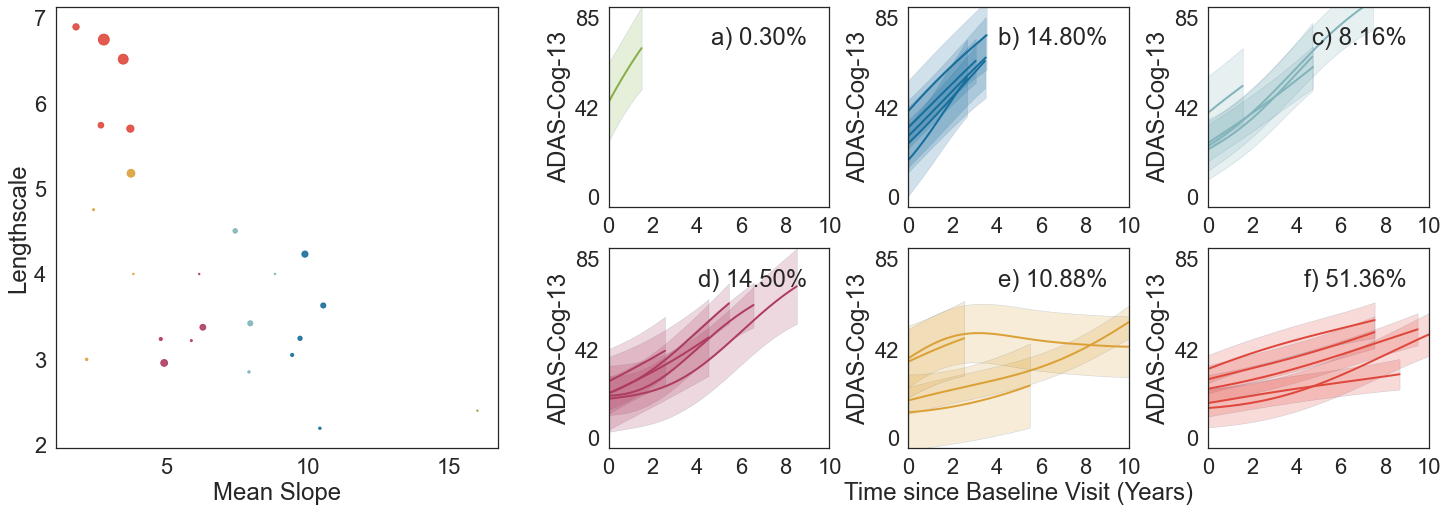

In [21]:
pcur = 'adni'
xlab_txt, ylab_txt, cur_model, cur_data, cmax_x, cx_step, cy_label, cy_minmax = set_format_params_nonals(pcur)
csum = summ_cluster_params(cur_model, cur_data)
csum_k, acf,  akfig, lax, raxs = plot_k_clust(cur_model, csum, num_clusters_set=6, 
                                    clust_thresh_size=1, col_palette=col_palette,
                                   max_x=cmax_x, x_step=cx_step, y_label=cy_label, y_minmax=cy_minmax,
                                    xlabel='', ylabel=ylab_txt)
_ = lax.set_xlabel('Mean Slope')
_ = raxs[4].set_xlabel(xlab_txt)

akfig.savefig('reports/supp_fig_adni_metaclust.pdf')

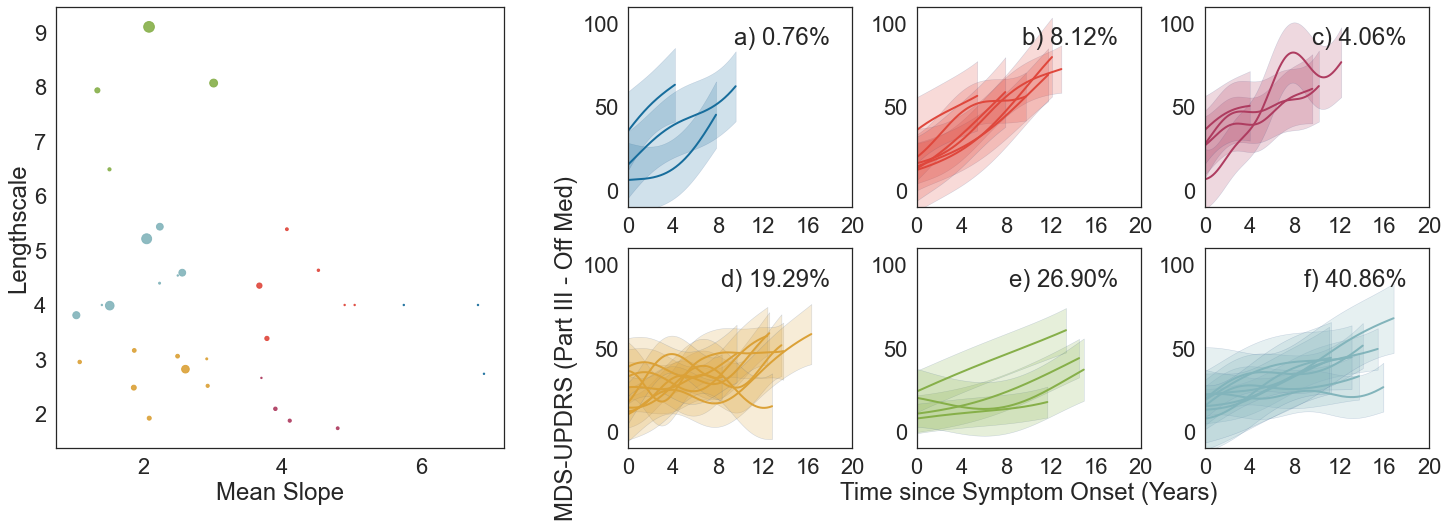

In [22]:
pcur = 'ppmi'
xlab_txt, ylab_txt, cur_model, cur_data, cmax_x, cx_step, cy_label, cy_minmax = set_format_params_nonals(pcur)
csum = summ_cluster_params(cur_model, cur_data)
csum = csum[csum['neg_linmap.A']<10] # remove strong outliers
csum_k, acf,  akfig, lax, raxs = plot_k_clust(cur_model, csum, num_clusters_set=6, 
                                    clust_thresh_size=1, col_palette=col_palette,
                                   max_x=cmax_x, x_step=cx_step, y_label=cy_label, y_minmax=cy_minmax,
                                    xlabel='', ylabel='')
_ = lax.set_xlabel('Mean Slope')
_ = raxs[4].set_xlabel(xlab_txt)
_ = raxs[3].set_ylabel(ylab_txt)

akfig.savefig('reports/supp_fig_ppmi_metaclust.pdf')

In [23]:
# check PIGD/TD with metaclusters

df_e = pd.DataFrame(zip(ppmi_map_mod.z, ppmi_data['SI'],), columns=['clust', 'PATNO'])
df_e = df_e.merge(csum.reset_index()[['clust','kalph', 'clust_size']], on='clust')
df_e = df_e.merge(td_stable, left_on='PATNO', right_on='PATNO', how='left')

met_freq_ppmi = check_clust_freq(df_e, feat='td-pigd-lab', ptid='PATNO', clustid='kalph')

In [24]:
met_freq_ppmi

,PIGD,TD,clust_size,TD_freq,PIGD_freq,TD_pval,PIGD_pval
kalph,,,,,,,
f,3,34,37,0.918919,0.081081,0.010986,0.010986
d,3,13,16,0.812500,0.187500,0.282422,0.282422
e,6,5,11,0.454545,0.545455,0.003894,0.003894
b,1,3,4,0.750000,0.250000,0.418788,0.418788


In [25]:
met_freq_ppmi.to_csv('reports/supp_table_TD-PIGD_freq.csv')